<a href="https://colab.research.google.com/github/anindabitm/zindi_yield_prediction/blob/main/yield_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
import pandas as pd
import gc
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler,LabelEncoder
import glob
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from keras.layers import Dense,Conv2D,TimeDistributed,Flatten,Input,AvgPool2D,LSTM,LeakyReLU,Concatenate,Dropout,Embedding
from keras import Model

In [ ]:
data = pd.read_csv('/content/drive/My Drive/yield-estimate/Train.csv')
data['train'] = 1
test = pd.read_csv('/content/drive/My Drive/yield-estimate/test_field_ids_with_year.csv')
test['Quality'] = 3
test['train'] = 0

In [ ]:
addl_data = pd.read_csv('/content/drive/My Drive/yield-estimate/fields_w_additional_info.csv')

In [ ]:
soil = addl_data.iloc[:,:12]
soil.head()

,Field_ID,soil_bdod_5-15cm_mean,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_ocs_0-30cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,soil_silt_5-15cm_mean,soil_soc_5-15cm_mean
0,MH2O0YH,118.0,257.0,85.0,463.0,2458.0,323.0,57.0,59.0,308.0,229.0,330.0
1,O9TURWL,120.0,288.0,84.0,462.0,2108.0,306.0,58.0,61.0,243.0,295.0,280.0
2,35AFSDD,120.0,263.0,102.0,495.0,1991.0,288.0,58.0,60.0,271.0,234.0,284.0
3,PM05EG9,122.0,206.0,66.0,431.0,2432.0,337.0,65.0,57.0,332.0,237.0,335.0
4,V7PZBCG,124.0,167.0,116.0,439.0,566.0,302.0,53.0,56.0,326.0,235.0,187.0


In [ ]:
soil['Quality'] = np.concatenate((data.Quality.values,test.Quality.values))
soil.head()

,Field_ID,soil_bdod_5-15cm_mean,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_ocs_0-30cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,soil_silt_5-15cm_mean,soil_soc_5-15cm_mean,Quality
0,MH2O0YH,118.0,257.0,85.0,463.0,2458.0,323.0,57.0,59.0,308.0,229.0,330.0,3
1,O9TURWL,120.0,288.0,84.0,462.0,2108.0,306.0,58.0,61.0,243.0,295.0,280.0,2
2,35AFSDD,120.0,263.0,102.0,495.0,1991.0,288.0,58.0,60.0,271.0,234.0,284.0,3
3,PM05EG9,122.0,206.0,66.0,431.0,2432.0,337.0,65.0,57.0,332.0,237.0,335.0,2
4,V7PZBCG,124.0,167.0,116.0,439.0,566.0,302.0,53.0,56.0,326.0,235.0,187.0,2


In [ ]:
soil.to_csv('/content/drive/My Drive/yield-estimate/Soil.csv',index=False)

In [ ]:
data.drop(['Yield'],axis=1,inplace=True)
data.shape

(2977, 4)

In [ ]:
data = pd.concat([data,test]).reset_index(drop=True)
data.head()

,Field_ID,Year,Quality,train
0,MH2O0YH,2019,3,1
1,O9TURWL,2019,2,1
2,35AFSDD,2019,3,1
3,PM05EG9,2019,2,1
4,V7PZBCG,2019,2,1


In [ ]:
climate=pd.DataFrame()
climate['Field_ID'] = addl_data['Field_ID']
climate['Year'] = data['Year']
climate['Quality'] = data['Quality']

In [ ]:
cols = addl_data.columns[12:]
cols = list(cols[:168])
fea = []
for col in cols:
  fea.append(re.sub("_\d+_", "",col))

for idx in tqdm(range(len(climate))):
  year = climate.loc[idx,'Year']
  field = climate.loc[idx,'Field_ID']
  if (year == 2016):
    col = list(range(12,180))
  elif (year == 2017):
    col = list(range(180,348))
  elif (year == 2018):
    col = list(range(348,516))
  else:
   col = list(range(516,684))

  climate.loc[idx,fea] = addl_data.iloc[idx,col].values
  
climate.head()

,Field_ID,Year,Quality,climate1_aet,climate1_def,climate1_pdsi,climate1_pet,climate1_pr,climate1_ro,climate1_soil,climate1_srad,climate1_swe,climate1_tmmn,climate1_tmmx,climate1_vap,climate1_vpd,climate1_vs,climate2_aet,climate2_def,climate2_pdsi,climate2_pet,climate2_pr,climate2_ro,climate2_soil,climate2_srad,climate2_swe,climate2_tmmn,climate2_tmmx,climate2_vap,climate2_vpd,climate2_vs,climate3_aet,climate3_def,climate3_pdsi,climate3_pet,climate3_pr,climate3_ro,climate3_soil,climate3_srad,climate3_swe,...,climate10_pdsi,climate10_pet,climate10_pr,climate10_ro,climate10_soil,climate10_srad,climate10_swe,climate10_tmmn,climate10_tmmx,climate10_vap,climate10_vpd,climate10_vs,climate11_aet,climate11_def,climate11_pdsi,climate11_pet,climate11_pr,climate11_ro,climate11_soil,climate11_srad,climate11_swe,climate11_tmmn,climate11_tmmx,climate11_vap,climate11_vpd,climate11_vs,climate12_aet,climate12_def,climate12_pdsi,climate12_pet,climate12_pr,climate12_ro,climate12_soil,climate12_srad,climate12_swe,climate12_tmmn,climate12_tmmx,climate12_vap,climate12_vpd,climate12_vs
0,MH2O0YH,2019,3,119.0,1405.0,370.0,1524.0,4.0,0.0,287.0,2543.0,0.0,112.0,285.0,1246.0,138.0,260.0,122.0,1367.0,260.0,1489.0,7.0,0.0,236.0,2609.0,0.0,116.0,297.0,1166.0,161.0,260.0,170.0,1464.0,120.0,1634.0,14.0,1.0,200.0,2585.0,0.0,...,-600.0,1191.0,96.0,5.0,99.0,2057.0,0.0,109.0,269.0,1637.0,80.0,250.0,791.0,357.0,-570.0,1148.0,83.0,4.0,93.0,2029.0,0.0,112.0,271.0,1615.0,85.0,240.0,1067.0,0.0,-400.0,1067.0,125.0,6.0,215.0,1880.0,0.0,100.0,267.0,1680.0,69.0,210.0
1,O9TURWL,2019,2,115.0,1376.0,410.0,1491.0,4.0,0.0,287.0,2581.0,0.0,108.0,288.0,1260.0,138.0,220.0,119.0,1362.0,290.0,1481.0,7.0,0.0,237.0,2639.0,0.0,118.0,305.0,1157.0,173.0,230.0,178.0,1518.0,160.0,1696.0,15.0,1.0,203.0,2652.0,0.0,...,-580.0,1228.0,79.0,4.0,102.0,2095.0,0.0,109.0,279.0,1640.0,90.0,230.0,743.0,413.0,-540.0,1156.0,78.0,4.0,96.0,2050.0,0.0,111.0,280.0,1628.0,93.0,200.0,1078.0,0.0,-360.0,1078.0,126.0,6.0,215.0,1883.0,0.0,99.0,273.0,1682.0,75.0,190.0
2,35AFSDD,2019,3,111.0,1401.0,410.0,1512.0,4.0,0.0,278.0,2571.0,0.0,109.0,288.0,1276.0,137.0,240.0,112.0,1384.0,290.0,1496.0,7.0,0.0,230.0,2629.0,0.0,119.0,306.0,1165.0,174.0,240.0,173.0,1548.0,160.0,1721.0,15.0,1.0,197.0,2632.0,0.0,...,-600.0,1240.0,73.0,4.0,100.0,2095.0,0.0,110.0,280.0,1644.0,91.0,240.0,718.0,435.0,-560.0,1153.0,75.0,4.0,93.0,2041.0,0.0,112.0,280.0,1637.0,93.0,200.0,1084.0,0.0,-360.0,1084.0,135.0,7.0,289.0,1875.0,0.0,100.0,274.0,1690.0,76.0,200.0
3,PM05EG9,2019,2,123.0,1378.0,370.0,1501.0,3.0,0.0,299.0,2550.0,0.0,110.0,282.0,1236.0,134.0,250.0,128.0,1325.0,250.0,1453.0,8.0,0.0,244.0,2612.0,0.0,115.0,295.0,1171.0,158.0,240.0,169.0,1475.0,120.0,1644.0,14.0,1.0,207.0,2592.0,0.0,...,-580.0,1161.0,106.0,5.0,102.0,2062.0,0.0,108.0,264.0,1648.0,73.0,240.0,826.0,297.0,-550.0,1123.0,86.0,4.0,95.0,2041.0,0.0,110.0,268.0,1619.0,81.0,220.0,1053.0,0.0,-390.0,1053.0,121.0,6.0,189.0,1898.0,0.0,98.0,263.0,1688.0,64.0,210.0
4,V7PZBCG,2019,2,643.0,988.0,270.0,1631.0,20.0,1.0,427.0,2438.0,0.0,161.0,320.0,1575.0,173.0,270.0,294.0,1370.0,140.0,1664.0,18.0,1.0,300.0,2576.0,0.0,174.0,332.0,1478.0,208.0,290.0,395.0,1409.0,-280.0,1804.0,35.0,2.0,234.0,2641.0,0.0,...,-590.0,1250.0,237.0,12.0,1179.0,2057.0,0.0,150.0,292.0,1998.0,89.0,240.0,1213.0,34.0,-550.0,1247.0,122.0,6.0,1123.0,2106.0,0.0,152.0,296.0,1960.0,99.0,250.0,1199.0,0.0,-380.0,1199.0,194.0,66.0,1214.0,1930.0,0.0,143.0,291.0,1972.0,87.0,270.0


In [ ]:
climate.to_csv('/content/drive/My Drive/yield-estimate/Climate.csv',index=False)

In [ ]:
climate.iloc[:,3:].values.reshape(4032,12,14)[:,0,:]

array([[ 119., 1405.,  370., ..., 1246.,  138.,  260.],
       [ 115., 1376.,  410., ..., 1260.,  138.,  220.],
       [ 111., 1401.,  410., ..., 1276.,  137.,  240.],
       ...,
       [1043.,  265.,  432., ..., 1931.,  105.,  289.],
       [1131.,  187.,  404., ..., 1850.,  111.,  273.],
       [1121.,  205.,  409., ..., 1851.,  111.,  277.]])

# Creating folds

In [ ]:
from sklearn.model_selection import train_test_split,KFold
kf = KFold(n_splits=5,shuffle=True,random_state=2020)
fold_df = train.copy(deep=True)
crop_yield = np.zeros(shape=(1055,1))
for fold,(train_index, test_index) in enumerate(kf.split(train.Field_ID.values,train.Yield.values)):
  fold_df.loc[test_index,f'fold'] = fold+1

fold_df.head()

In [ ]:
fold_df.to_csv('/content/drive/My Drive/yield-estimate/folds.csv',index=False)

# Data reading section

In [ ]:
# Copying in the zip files from Google Drive (alternately just upload them)
!cp '/content/drive/My Drive/yield-estimate/image_arrays_train.zip' .
!cp '/content/drive/My Drive/yield-estimate/image_arrays_test.zip' .

In [ ]:
# Extract
!unzip -q image_arrays_train.zip
!unzip -q image_arrays_test.zip

In [ ]:
!ls

drive		   image_arrays_test.zip  image_arrays_train.zip
image_arrays_test  image_arrays_train	  sample_data


In [ ]:
train_fns = glob.glob('./image_arrays_train/*.*')
test_fns = glob.glob('./image_arrays_test/*.*')
print('The number of training files are:',len(train_fns),' and number of test filenames are:',len(test_fns))

The number of training files are: 2977  and number of test filenames are: 1055


In [ ]:
train = pd.read_csv('/content/drive/My Drive/yield-estimate/Train.csv')
print(train.shape)
train.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


In [ ]:
ss = pd.read_csv('/content/drive/My Drive/yield-estimate/SampleSubmission.csv')
print(ss.shape)
ss.head()

(1055, 2)


,Field_ID,Yield
0,E9UZCEA,0
1,1WGGS1Q,0
2,EG2KXE2,0
3,HC3GQXF,0
4,7AK6GFK,0


In [ ]:
train = train.loc[(train['Quality']==3) | (train['Quality']==2),:].reset_index(drop=True)
train.shape

(2552, 4)

In [ ]:
train.head()

,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


In [ ]:
def get_array(df,length,train_status):
  array = []
  for idx in tqdm(range(length)):
    if train_status == 1:
      fn = './image_arrays_train/' + df.loc[idx,'Field_ID'] + '.npy'

    else:
      fn = './image_arrays_test/' + df.loc[idx,'Field_ID'] + '.npy'
    
    img = np.load(fn)[:,:32,:32]
    img = img.transpose((1,2,0))
    img = img.reshape(32,32,30,-1)
    img = img.transpose((3,0,1,2))
    img = img/np.max(img)
    img = img.astype('float16')
    array.append(img)
  return np.stack(array)

In [ ]:
X = get_array(train,len(train),1)

In [ ]:
X.shape

(2552, 12, 32, 32, 30)

In [ ]:
np.save('/content/drive/My Drive/yield-estimate/train',X)

In [ ]:
test = get_array(ss,len(ss),0)
print(test.shape)
np.save('/content/drive/My Drive/yield-estimate/test',test)


(1055, 12, 32, 32, 30)


# Modelling

In [ ]:
#train = pd.read_csv('/content/drive/My Drive/yield-estimate/Train.csv')
#train = train.loc[(train['Quality']==3) | (train['Quality']==2),:].reset_index(drop=True)
train = pd.read_csv('/content/drive/My Drive/yield-estimate/folds.csv')
train.shape

(2552, 5)

In [ ]:
ss = pd.read_csv('/content/drive/My Drive/yield-estimate/SampleSubmission.csv')
print(ss.shape)

(1055, 2)


In [ ]:
climate_df = pd.read_csv('/content/drive/My Drive/yield-estimate/Climate.csv')
climate_train = climate_df.iloc[:2977]
climate_train = climate_train.loc[(climate_train['Quality']==3) | (climate_train['Quality']==2),:].reset_index(drop=True)
climate_train.fillna(value=0,inplace=True)
climate_train.shape

(2552, 171)

In [ ]:
soil = pd.read_csv('/content/drive/My Drive/yield-estimate/Soil.csv')
soil_train = soil.iloc[:2977]
soil_train = soil_train.loc[(soil_train['Quality']==3) | (soil_train['Quality']==2),:].reset_index(drop=True)
soil_train.fillna(value=0,inplace=True)
soil_train.shape

(2552, 13)

In [ ]:
test_year = pd.read_csv('/content/drive/My Drive/yield-estimate/test_field_ids_with_year.csv')
test_year.head()

,Field_ID,Year
0,E9UZCEA,2019
1,1WGGS1Q,2019
2,EG2KXE2,2019
3,HC3GQXF,2019
4,7AK6GFK,2019


In [ ]:
X1 = np.load('/content/drive/My Drive/yield-estimate/train.npy')

In [ ]:
X1.shape

(2552, 12, 32, 32, 30)

In [ ]:
X2 = climate_train.iloc[:,3:].values
y = train.Yield.values
X2.shape,y.shape

((2552, 168), (2552,))

In [ ]:
scaler1 = StandardScaler()
X2 = scaler1.fit_transform(X2)
X2 = X2.reshape(-1,12,14)
X2.shape

(2552, 12, 14)

In [ ]:
X3 = soil_train.iloc[:,1:12].values
scaler2 = StandardScaler()
X3 = scaler2.fit_transform(X3)
X3.shape

(2552, 11)

In [ ]:
X4 = train.Year.values
le = LabelEncoder()
X4 = le.fit_transform(X4)
X4.shape

(2552,)

In [ ]:
test1 = np.load('/content/drive/My Drive/yield-estimate/test.npy')
test1.shape

(1055, 12, 32, 32, 30)

In [ ]:
climate_test = climate_df.iloc[2977:]
climate_test.fillna(value=0,inplace=True)
climate_test.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


(1055, 171)

In [ ]:
soil_test = soil.iloc[2977:]
soil_test.fillna(value=0,inplace=True)
soil_test.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


(1055, 13)

In [ ]:
test2 = climate_test.iloc[:,3:].values
test2 = scaler1.transform(test2)
test2 = test2.reshape(-1,12,14)
test2.shape

(1055, 12, 14)

In [ ]:
test3 = soil_test.iloc[:,1:12].values
test3 = scaler2.transform(test3)
test3.shape

(1055, 11)

In [ ]:
test4 = test_year.Year.values
test4 = le.transform(test4)
test4.shape

(1055,)

In [ ]:
def get_model():
  input1 = Input(shape=(12,32,32,30))
  input2 = Input(shape=(12,14))
  input3 = Input(shape=(11))
  input4 = Input(shape=(1))
  x = TimeDistributed(Conv2D(filters=256,kernel_size=(3,3),strides=(2,2)))(input1)
  x = TimeDistributed(LeakyReLU())(x)
  x = TimeDistributed(Conv2D(filters=512,kernel_size=(3,3),strides=(2,2)))(x)
  x = TimeDistributed(LeakyReLU())(x)
  x = TimeDistributed(Conv2D(filters=1024,kernel_size=(3,3),strides=(2,2)))(x)
  x = TimeDistributed(LeakyReLU())(x)
  x = TimeDistributed(Flatten())(x)
  concat1 = Concatenate()([x,input2])
  x = LSTM(512,activation="tanh",return_sequences=True)(concat1)
  x = Dropout(0.3)(x)
  x = LeakyReLU()(x)
  x = LSTM(512,activation="tanh")(x)
  x = Dropout(0.3)(x)
  x = LeakyReLU()(x)
  embed = Embedding(input_dim=5,output_dim=50,input_length=1)(input4)
  embed = Flatten()(embed)
  concat2 = Concatenate()([x,input3,embed])
  x = Dense(256,activation=None)(concat2)
  x = LeakyReLU()(x)
  x = Dense(64,activation=None)(x)
  x = LeakyReLU()(x)
  output = Dense(1)(x)
  model = Model(inputs=[input1,input2,input3,input4],outputs=output)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=tf.keras.metrics.RootMeanSquaredError())
  #model.summary()
  return model

In [ ]:
EPOCHS = 10
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * 8
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

In [ ]:
##########################FOLD 1##################################################
train_index = list(train.loc[train['fold']!=1].index)
test_index = list(train.loc[train['fold']==1].index)

x_train1,x_valid1 = X1[train_index],X1[test_index]
x_train2,x_valid2 = X2[train_index],X2[test_index]
x_train3,x_valid3 = X3[train_index],X3[test_index]
x_train4,x_valid4 = X4[train_index],X4[test_index]
y_train,y_valid = y[train_index],y[test_index]
print(x_train1.shape,x_train2.shape,x_train3.shape,x_train4.shape,x_valid1.shape,x_valid2.shape,x_valid3.shape,x_valid4.shape)
   
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
  
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/yield-estimate/model/model_1.h5',
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)
model = get_model()
#model.fit(x=(x_train1,x_train2,x_train3,x_train4),y=y_train,epochs=EPOCHS,validation_data=((x_valid1,x_valid2,x_valid3,x_valid4),y_valid),callbacks=[model_checkpoint_callback],batch_size=8) 

(2041, 12, 32, 32, 30) (2041, 12, 14) (2041, 11) (2041,) (511, 12, 32, 32, 30) (511, 12, 14) (511, 11) (511,)


Epoch 1/5
4/4 [==============================] - 23s 3s/step - loss: 12.7342 - root_mean_squared_error: 3.5683
Epoch 2/5
4/4 [==============================] - 5s 1s/step - loss: 12.5381 - root_mean_squared_error: 3.5408
Epoch 3/5
4/4 [==============================] - 5s 1s/step - loss: 9.8198 - root_mean_squared_error: 3.1106
Epoch 4/5
4/4 [==============================] - 4s 857ms/step - loss: 16.8836 - root_mean_squared_error: 3.9412


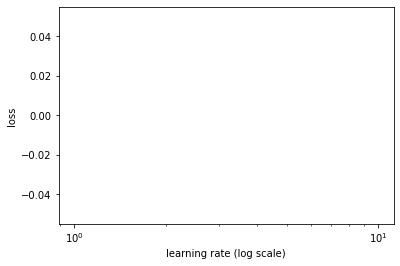

In [ ]:
lr_finder = LRFinder(model)
lr_finder.find((x_train1,x_train2,x_train3,x_train4),y_train, start_lr=0.0000001, end_lr=100, batch_size=512, epochs=5)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

In [ ]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: '0', 1: '1', 2: '2', 
        3: '3', 4: '4', 5: '5', 6: '6', 7:'7',
        8: '8', 9: '9'}

from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train,y_train, start_lr, end_lr, batch_size=64, epochs=1):
        x_train1 = x_train[0]
        x_train2 = x_train[1]
        x_train3 = x_train[2]
        x_train4 = x_train[3]
               
        num_batches = epochs * x_train1.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit((x_train1,x_train2,x_train3,x_train4), y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

In [ ]:
##########################FOLD 2##################################################
train_index = list(train.loc[train['fold']!=2].index)
test_index = list(train.loc[train['fold']==2].index)

x_train1,x_valid1 = X1[train_index],X1[test_index]
x_train2,x_valid2 = X2[train_index],X2[test_index]
x_train3,x_valid3 = X3[train_index],X3[test_index]
x_train4,x_valid4 = X4[train_index],X4[test_index]
y_train,y_valid = y[train_index],y[test_index]
print(x_train1.shape,x_train2.shape,x_train3.shape,x_train4.shape,x_valid1.shape,x_valid2.shape,x_valid3.shape,x_valid4.shape)
   
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
  
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/yield-estimate/model/model_2.h5',
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)
model = get_model()
model.fit(x=(x_train1,x_train2,x_train3,x_train4),y=y_train,epochs=EPOCHS,validation_data=((x_valid1,x_valid2,x_valid3,x_valid4),y_valid),callbacks=[model_checkpoint_callback]) 

(2041, 12, 32, 32, 30) (2041, 12, 14) (2041, 11) (2041,) (511, 12, 32, 32, 30) (511, 12, 14) (511, 11) (511,)
Epoch 1/12
64/64 [==============================] - 17s 111ms/step - loss: 7.9069 - root_mean_squared_error: 2.7742 - val_loss: 2.5049 - val_root_mean_squared_error: 1.5827
Epoch 2/12
64/64 [==============================] - 5s 85ms/step - loss: 2.4967 - root_mean_squared_error: 1.5798 - val_loss: 2.4383 - val_root_mean_squared_error: 1.5615
Epoch 3/12
64/64 [==============================] - 5s 83ms/step - loss: 2.5823 - root_mean_squared_error: 1.6063 - val_loss: 2.3697 - val_root_mean_squared_error: 1.5394
Epoch 4/12
64/64 [==============================] - 5s 84ms/step - loss: 2.4018 - root_mean_squared_error: 1.5494 - val_loss: 2.3198 - val_root_mean_squared_error: 1.5231
Epoch 5/12
64/64 [==============================] - 6s 87ms/step - loss: 2.3694 - root_mean_squared_error: 1.5383 - val_loss: 2.3075 - val_root_mean_squared_error: 1.5191
Epoch 6/12
64/64 [===============

In [ ]:
import gc
del model
gc.collect()

1984

In [ ]:
##########################FOLD 3##################################################
train_index = list(train.loc[train['fold']!=3].index)
test_index = list(train.loc[train['fold']==3].index)

x_train1,x_valid1 = X1[train_index],X1[test_index]
x_train2,x_valid2 = X2[train_index],X2[test_index]
x_train3,x_valid3 = X3[train_index],X3[test_index]
x_train4,x_valid4 = X4[train_index],X4[test_index]
y_train,y_valid = y[train_index],y[test_index]
print(x_train1.shape,x_train2.shape,x_train3.shape,x_train4.shape,x_valid1.shape,x_valid2.shape,x_valid3.shape,x_valid4.shape)
   
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
  
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/yield-estimate/model/model_3.h5',
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)
model = get_model()
model.fit(x=(x_train1,x_train2,x_train3,x_train4),y=y_train,epochs=EPOCHS,validation_data=((x_valid1,x_valid2,x_valid3,x_valid4),y_valid),callbacks=[model_checkpoint_callback]) 

(2042, 12, 32, 32, 30) (2042, 12, 14) (2042, 11) (2042,) (510, 12, 32, 32, 30) (510, 12, 14) (510, 11) (510,)
Epoch 1/12
64/64 [==============================] - 9s 108ms/step - loss: 7.1304 - root_mean_squared_error: 2.6395 - val_loss: 2.8183 - val_root_mean_squared_error: 1.6788
Epoch 2/12
64/64 [==============================] - 6s 88ms/step - loss: 3.7555 - root_mean_squared_error: 1.9284 - val_loss: 2.7720 - val_root_mean_squared_error: 1.6649
Epoch 3/12
64/64 [==============================] - 6s 89ms/step - loss: 2.4322 - root_mean_squared_error: 1.5593 - val_loss: 2.7894 - val_root_mean_squared_error: 1.6702
Epoch 4/12
64/64 [==============================] - 6s 87ms/step - loss: 2.2293 - root_mean_squared_error: 1.4923 - val_loss: 2.7330 - val_root_mean_squared_error: 1.6532
Epoch 5/12
64/64 [==============================] - 6s 90ms/step - loss: 2.3538 - root_mean_squared_error: 1.5335 - val_loss: 2.6633 - val_root_mean_squared_error: 1.6320
Epoch 6/12
64/64 [================

In [ ]:
del model
gc.collect()

1757

In [ ]:
##########################FOLD 4##################################################
train_index = list(train.loc[train['fold']!=4].index)
test_index = list(train.loc[train['fold']==4].index)

x_train1,x_valid1 = X1[train_index],X1[test_index]
x_train2,x_valid2 = X2[train_index],X2[test_index]
x_train3,x_valid3 = X3[train_index],X3[test_index]
x_train4,x_valid4 = X4[train_index],X4[test_index]
y_train,y_valid = y[train_index],y[test_index]
print(x_train1.shape,x_train2.shape,x_train3.shape,x_train4.shape,x_valid1.shape,x_valid2.shape,x_valid3.shape,x_valid4.shape)
   
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
  
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/yield-estimate/model/model_4.h5',
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)
model = get_model()
model.fit(x=(x_train1,x_train2,x_train3,x_train4),y=y_train,epochs=EPOCHS,validation_data=((x_valid1,x_valid2,x_valid3,x_valid4),y_valid),callbacks=[model_checkpoint_callback]) 

(2042, 12, 32, 32, 30) (2042, 12, 14) (2042, 11) (2042,) (510, 12, 32, 32, 30) (510, 12, 14) (510, 11) (510,)
Epoch 1/12
64/64 [==============================] - 9s 107ms/step - loss: 6.2564 - root_mean_squared_error: 2.4606 - val_loss: 2.7801 - val_root_mean_squared_error: 1.6674
Epoch 2/12
64/64 [==============================] - 6s 87ms/step - loss: 2.6317 - root_mean_squared_error: 1.6217 - val_loss: 2.4376 - val_root_mean_squared_error: 1.5613
Epoch 3/12
64/64 [==============================] - 5s 85ms/step - loss: 2.4923 - root_mean_squared_error: 1.5780 - val_loss: 2.6705 - val_root_mean_squared_error: 1.6342
Epoch 4/12
64/64 [==============================] - 6s 92ms/step - loss: 2.5657 - root_mean_squared_error: 1.5981 - val_loss: 2.3583 - val_root_mean_squared_error: 1.5357
Epoch 5/12
64/64 [==============================] - 6s 90ms/step - loss: 2.3381 - root_mean_squared_error: 1.5283 - val_loss: 2.3959 - val_root_mean_squared_error: 1.5479
Epoch 6/12
64/64 [================

In [ ]:
del model
gc.collect()

1799

In [ ]:
##########################FOLD 5##################################################
train_index = list(train.loc[train['fold']!=5].index)
test_index = list(train.loc[train['fold']==5].index)

x_train1,x_valid1 = X1[train_index],X1[test_index]
x_train2,x_valid2 = X2[train_index],X2[test_index]
x_train3,x_valid3 = X3[train_index],X3[test_index]
x_train4,x_valid4 = X4[train_index],X4[test_index]
y_train,y_valid = y[train_index],y[test_index]
print(x_train1.shape,x_train2.shape,x_train3.shape,x_train4.shape,x_valid1.shape,x_valid2.shape,x_valid3.shape,x_valid4.shape)
   
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
  
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/yield-estimate/model/model_5.h5',
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)
model = get_model()
model.fit(x=(x_train1,x_train2,x_train3,x_train4),y=y_train,epochs=EPOCHS,validation_data=((x_valid1,x_valid2,x_valid3,x_valid4),y_valid),callbacks=[model_checkpoint_callback]) 

(2042, 12, 32, 32, 30) (2042, 12, 14) (2042, 11) (2042,) (510, 12, 32, 32, 30) (510, 12, 14) (510, 11) (510,)
Epoch 1/12
64/64 [==============================] - 9s 113ms/step - loss: 7.0846 - root_mean_squared_error: 2.6485 - val_loss: 2.1682 - val_root_mean_squared_error: 1.4725
Epoch 2/12
64/64 [==============================] - 6s 90ms/step - loss: 2.9360 - root_mean_squared_error: 1.7129 - val_loss: 2.0774 - val_root_mean_squared_error: 1.4413
Epoch 3/12
64/64 [==============================] - 5s 86ms/step - loss: 2.6303 - root_mean_squared_error: 1.6203 - val_loss: 2.2474 - val_root_mean_squared_error: 1.4991
Epoch 4/12
64/64 [==============================] - 6s 91ms/step - loss: 2.4174 - root_mean_squared_error: 1.5543 - val_loss: 2.0153 - val_root_mean_squared_error: 1.4196
Epoch 5/12
64/64 [==============================] - 6s 90ms/step - loss: 2.3822 - root_mean_squared_error: 1.5429 - val_loss: 2.1115 - val_root_mean_squared_error: 1.4531
Epoch 6/12
64/64 [================

In [ ]:
del model
gc.collect()

1799

In [ ]:
!pip install keras-lr-finder

In [ ]:
from keras_lr_finder import LRFinder

In [ ]:
lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train, 0.0001, 1, 512, 5)

Epoch 1/5
4/4 [==============================] - 82s 19s/step - loss: 12.0197 - root_mean_squared_error: 3.4661
Epoch 2/5
4/4 [==============================] - 75s 19s/step - loss: 5.2700 - root_mean_squared_error: 2.2946
Epoch 3/5
4/4 [==============================] - 73s 18s/step - loss: 43.5195 - root_mean_squared_error: 5.6437


In [ ]:
lr_finder.plot_loss()

# Generating predictions

In [ ]:
crop_yield = np.zeros(shape=(1055,1))

model = tf.keras.models.load_model('/content/drive/My Drive/yield-estimate/model/model_1.h5')
crop_yield += model.predict((test1,test2,test3,test4))
del model
gc.collect()
model = tf.keras.models.load_model('/content/drive/My Drive/yield-estimate/model/model_2.h5')
crop_yield += model.predict((test1,test2,test3,test4))
del model
gc.collect()
model = tf.keras.models.load_model('/content/drive/My Drive/yield-estimate/model/model_3.h5')
crop_yield += model.predict((test1,test2,test3,test4))
del model
gc.collect()
model = tf.keras.models.load_model('/content/drive/My Drive/yield-estimate/model/model_4.h5')
crop_yield += model.predict((test1,test2,test3,test4))
del model
gc.collect()
model = tf.keras.models.load_model('/content/drive/My Drive/yield-estimate/model/model_5.h5')
crop_yield += model.predict((test1,test2,test3,test4))
del model
gc.collect()

7861

In [ ]:
crop_yield[:10]

array([[15.70167828],
       [18.30293512],
       [17.15458751],
       [16.65882707],
       [16.39486885],
       [21.53106165],
       [24.06424379],
       [23.01271152],
       [19.70296931],
       [21.13050795]])

In [ ]:
ss['Yield'] = crop_yield/5
ss.head()

,Field_ID,Yield
0,E9UZCEA,3.140336
1,1WGGS1Q,3.660587
2,EG2KXE2,3.430918
3,HC3GQXF,3.331765
4,7AK6GFK,3.278974


In [ ]:
ss.to_csv('/content/drive/My Drive/yield-estimate/sub_5fold.csv',index=False)